# EEGMapping: Group Analysis (Local Data)

Words, words, words.

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import pickle

import mne
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import ttest_1samp, ttest_ind, sem, pearsonr

from fooof import FOOOF, FOOOFGroup

In [2]:
# Import custom code for this analysis
% autoreload 2
from plots import *
from utilities import *
from analysis import *

## Settings

Put all general settings here. 

In [3]:
# Set whether to save out all the figures
SAVE_FIGS = False

# Whether to make the data
MASKING = True

# This controls how much stuff MNE prints out
mne.set_log_level(verbose=False)

# Loading information

In [4]:
#lOADING CHANNELS FROM txt
#save_path = "C:\\Users\\abc\\EEG-MNE\\data"
save_path = '../data'

chan_dat = 'channel_dat.txt'
chan_file = os.path.join(save_path, chan_dat)

In [5]:
# Set up subject numbers
subj_dat_num = list(range(3502, 3516))
subj_dat_num2 =list(range(3001, 3015))
all_subj = subj_dat_num + subj_dat_num2

In [10]:
# #LOADING CHANNELS from raw data
# # This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\PBA_Data'

# These should stay the same
subj_dat_fname = '._3001_resampled.set'
subj_dat_fname = '3002_resampled.set'
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)

# For Tom's Computer
# save_path = '/Users/tom/Documents/Research/1-Projects/Phase/Experiments/PBA/2-Data/PBA-3/2-processed/EEG'
# eeg_dat = mne.io.read_raw_eeglab(os.path.join(save_path, '3002_resampled.set'), preload=True, verbose=False)

Events like the following will be dropped entirely: ['Exp_Block_Start', 'Flash_exp', 'RETURN pressed', 'Lines_On', 'Fix_On'], 26 in total
5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.


<ipython-input-10-229a4e1bb9c6>:9: RuntimeWarning: Events like the following will be dropped entirely: ['Exp_Block_Start', 'Flash_exp', 'RETURN pressed', 'Lines_On', 'Fix_On'], 26 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)
<ipython-input-10-229a4e1bb9c6>:9: RuntimeWarning: 5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)


In [11]:
# Load and set the montage for the data
montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(montage)

<RawEEGLAB  |  3002_resampled.fdt, n_channels x n_times : 65 x 1896482 (3793.0 sec), ~940.6 MB, data loaded>

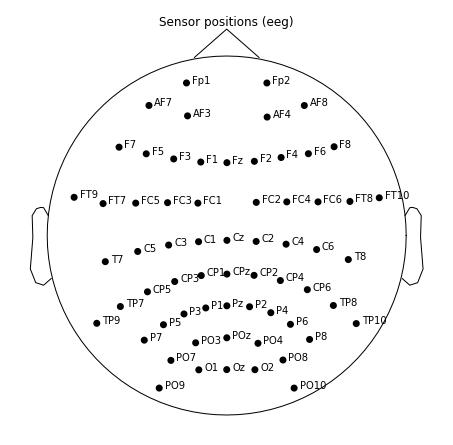

In [12]:
# Check the sensor map
eeg_dat.plot_sensors(show_names=True);

In [13]:
# Extract channel positions from a subjects data object
pos_new = np.asarray([ch['loc'][:3] for ch in eeg_dat.info['chs']])

# Drop stim channel
pos_new = pos_new[:-1, :]

In [14]:
# Update montage with channel positions
montage.pos = pos_new
pos = montage.get_pos2d()
montage = None

# DATA SET UP

In [15]:
# Load oscillations data
rtPB_rest_results = load_pickle('rtPB_rest_results')
rtPB_trial_results = load_pickle('rtPB_trial_results')
PBA_rest_results = load_pickle('PBA_rest_results')
PBA_trial_results = load_pickle('PBA_trial_results')

In [17]:
# Load exponent data
rtPB_rest_exponent_results = load_pickle('rtPB_rest_slope_results')
rtPB_trial_exponent_results = load_pickle('rtPB_trial_slope_results')
PBA_rest_exponent_results = load_pickle('PBA_rest_slope_results')
PBA_trial_exponent_results = load_pickle('PBA_trial_slope_results')

## Masking

In [18]:
# Set the channel cluster of interest
pos_ch_cluster = ['Oz','O1','O2','POz','PO3','PO4','PO7','PO8','PO9','PO10']
# Check the indices for the channel cluster
pos_ch_cluster_index = masking_cluster(pos_ch_cluster, eeg_dat)

# Analyses across STATE

In [19]:
# Set up date for state plots
rtpb_all_osc_data = [rtPB_trial_results, rtPB_rest_results]
pba_all_osc_data = [PBA_trial_results, PBA_rest_results]
comb_all_osc_data = [combine_groups_dict(rtPB_trial_results, PBA_trial_results),
                     combine_groups_dict(rtPB_rest_results, PBA_rest_results)]

# Make list of possible groups to run
groups_oscs = [rtpb_all_osc_data, pba_all_osc_data, comb_all_osc_data]

rtpb_all_exponent_data = [rtPB_trial_exponent_results, rtPB_rest_exponent_results]
pba_all_exponent_data = [PBA_trial_exponent_results, PBA_rest_exponent_results]
comb_all_exponent_data = [combine_groups_array(rtPB_trial_exponent_results, PBA_trial_exponent_results),
                       combine_groups_array(rtPB_rest_exponent_results, PBA_rest_exponent_results)]

# Make list of possible groups to run
groups_exponents = [rtpb_all_exponent_data, pba_all_exponent_data, comb_all_exponent_data]

# Set labels for group lists
labels = ['rtpb', 'pba', 'comb']

C:\Users\abc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\abc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\abc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\abc\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


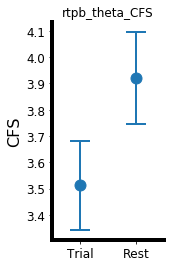

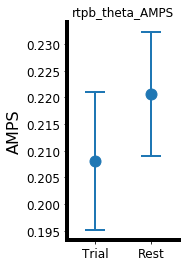

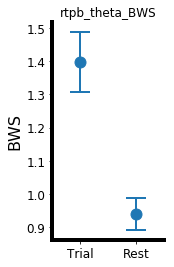

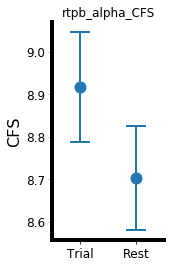

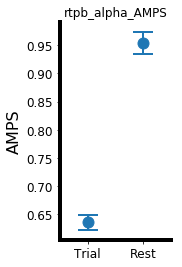

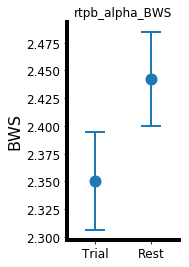

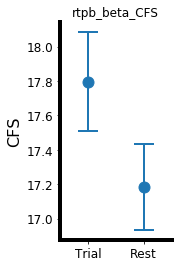

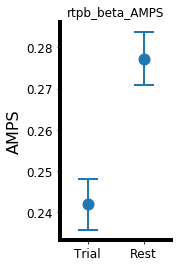

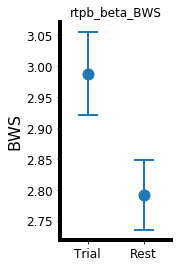

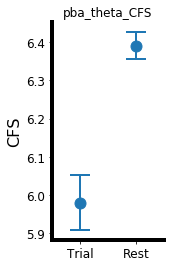

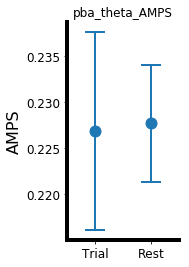

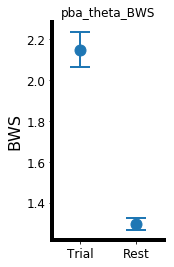

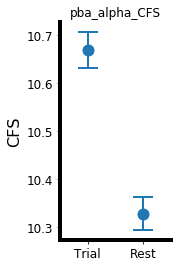

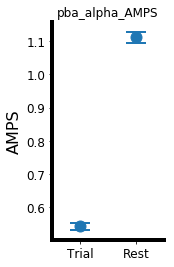

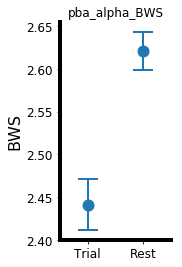

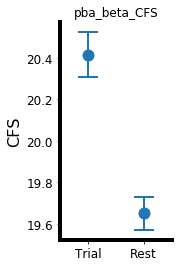

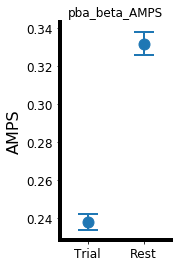

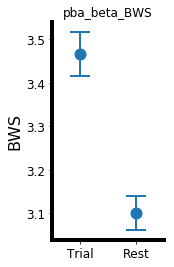

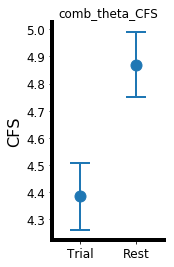

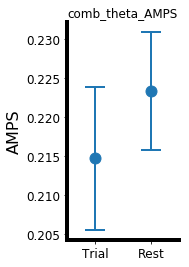

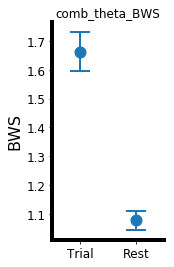

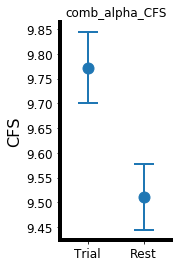

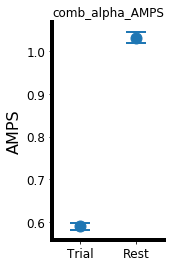

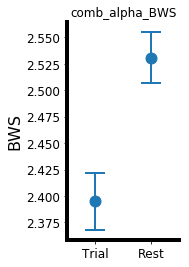

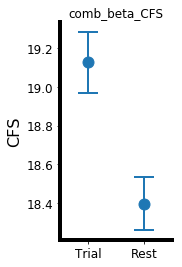

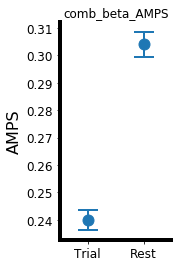

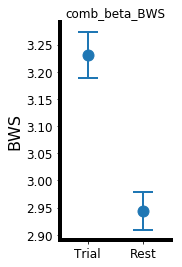

In [20]:
# Run analysis across state - oscs
corr_dicts = []
for label, group in zip(labels, groups_oscs):
    corr_dicts.append(run_state_dict(group, label, False, SAVE_FIGS))

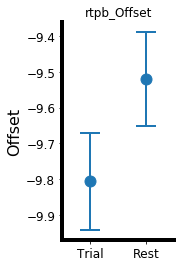

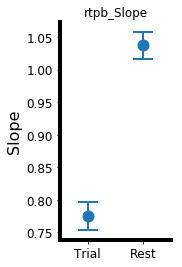

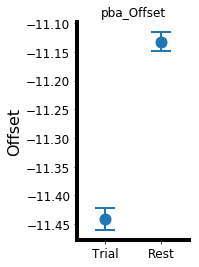

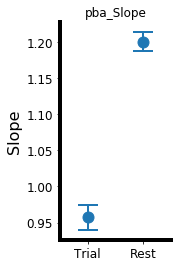

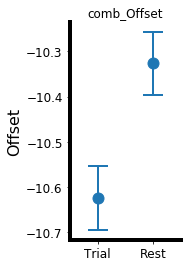

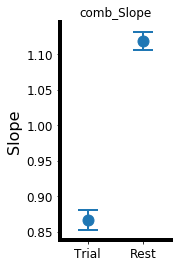

In [21]:
# Run analysis across state - exponent
for label, group in zip(labels, groups_exponents):
    run_state_array(group, label, False, ['Offset', 'Exponent'], SAVE_FIGS)

# Analyses Across SPACE

In [ ]:
spatial_corr_trial

In [ ]:
# Make topos, for each state, within and between datasets, for all features and bands
spatial_corr_trial = make_topos_dict([PBA_trial_results, rtPB_trial_results],
                                     label="Trial", eeg_dat_info=eeg_dat.info, pos=pos, save_fig=SAVE_FIGS)
spatial_corr_rest = make_topos_dict([PBA_rest_results, rtPB_rest_results],label="Rest",
                                    eeg_dat_info=eeg_dat.info, pos=pos, save_fig=SAVE_FIGS)
spatial_exponent_corr_trial = make_topos_array([PBA_trial_exponent_results, rtPB_trial_exponent_results],
                                            label="Trial", eeg_dat_info=eeg_dat.info, pos=pos,
                                            feats=['Offsets', 'Exponent'], save_fig=SAVE_FIGS)
spatial_exponent_corr_rest = make_topos_array([PBA_rest_exponent_results, rtPB_rest_exponent_results], 
                                            label="Rest", eeg_dat_info=eeg_dat.info, pos=pos,                                             
                                            feats=['Offsets', 'Exponent'], save_fig=SAVE_FIGS)

# Spatial Correlations Between Bands

In [ ]:

index = group_bands.keys()
d_corrm = pd.DataFrame(index=index, columns=index, dtype = float)
#Dataframe for correlaton matrix
for band in group_bands:
    data1 = group_bands[band][:,features[feature]]
    for band2 in group_bands:
        data2 = group_bands[band2][:,features[feature]]
        masked_arr1=mask_nan_array(data1)
        masked_arr2=mask_nan_array(data2)
        corr_val = pearsonr(data1, data2)[0]
        d_corrm.loc[band, band2] = corr_val



In [ ]:
plt.imshow(d_corrm)

# Analyses Across TIME

In [ ]:
PBA_across_oscs_corr_trial = run_dict_across_blocks('PBA', PBA_trial_results, pos_ch_cluster_index, SAVE_FIGS)
rtPB_across_oscs_corr_trial = run_dict_across_blocks('rtPB', rtPB_trial_results, pos_ch_cluster_index, SAVE_FIGS)

PBA_across_exponent_corr_trial = run_array_across_blocks('PBA', PBA_trial_exponent_results,
                                                      pos_ch_cluster_index, ['Offset', 'Slope'], SAVE_FIGS)
rtPB_across_exponent_corr_trial = run_array_across_blocks('rtPB', rtPB_trial_exponent_results,
                                                       pos_ch_cluster_index, ['Offset', 'Slope'], SAVE_FIGS)

In [ ]:
# Check correlations for BGs
print(rtPB_across_exponent_corr_trial)
print(PBA_across_exponent_corr_trial)

In [ ]:
# Check correlations across Oscs
print(rtPB_across_oscs_corr_trial)
print(PBA_across_oscs_corr_trial)

In [ ]:
rtPB_rest_results['alpha'].shape

In [ ]:
slo_dat.shape

### Correlations between two rest blocks

In [ ]:
# Ca
corrs = np.zeros(shape=[14, 4])
osc_dat = rtPB_rest_results['alpha']
slo_dat = rtPB_rest_exponent_results
corr_labels = ['Alpha CF', 'Alpha PWS', 'Alpha BW', '1/f Slope']

for feat_ind in range(dat.shape[3]):
    cur_corrs = []
    for subj_ind in range(dat.shape[0]):
        r_val, p_val = pearsonr(dat[subj_ind, 0, :, feat_ind], dat[subj_ind, 1, :, feat_ind])
        corrs[subj_ind-1, feat_ind] = r_val

for subj_ind in range(slo_dat.shape[0]):
    r_val, p_val = pearsonr(slo_dat[subj_ind, 0, :, 1], dat[subj_ind, 1, :, 1])
    corrs[subj_ind-1, 3] = r_val
    
# Drop nan rows from corrs
corrs = corrs[~np.isnan(corrs).any(axis=1)]

In [ ]:
plot_corrs_boxplot(corrs, corr_labels, 'AcrossRestCorrs', SAVE_FIGS)
plt.savefig('RestCorrs.png', bbox_inches='tight', dpi=300)

# Subject Variability Plots

In [ ]:
# Get all rest
all_rest = combine_groups_dict(rtPB_rest_results, PBA_rest_results)
rest_alphas = all_rest['alpha'][:, 30, :]

In [ ]:
# Plot rest alpha variability
plot_oscillations(rest_alphas, SAVE_FIGS, save_name='OscillationVariability')
plt.savefig('OscillationVariability')

In [ ]:
# Get all aperiodics
all_exponents = combine_groups_array(rtPB_rest_exponent_results, PBA_rest_exponent_results)

In [ ]:
# Plot aperiodic variability
plot_aperiodic(all_exponents[:, 30, :], SAVE_FIGS, save_name='BackgroundVariability')
plt.savefig('BackgroundVariability')